# Exploratory Data Analysis

The exploratory data analysis for [Nature](https://www.kaggle.com/datasets/heyitsfahd/nature) dataset.

**Essential information about the dataset:**
- the dataset contains 100 969 images both x64 and x128 resolution,
- the dataset contains images in 4 classes: City, Mountain, Fire, Lake,
- all images are the same size,
- all images are in *.jpg* format,
- there are no corrupted or missing images,
- all images are colored (RGB),
- there are no duplicates, but some images are similar, the images are frames from the videos, so there are similarities between the frames, but the images are still different enough to carry a new information.


## Imports

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchvision import models, transforms
from tqdm import tqdm

In [2]:
data_path = "data/Nature"  # original data path 
directories = os.listdir(data_path)

## Sample Images

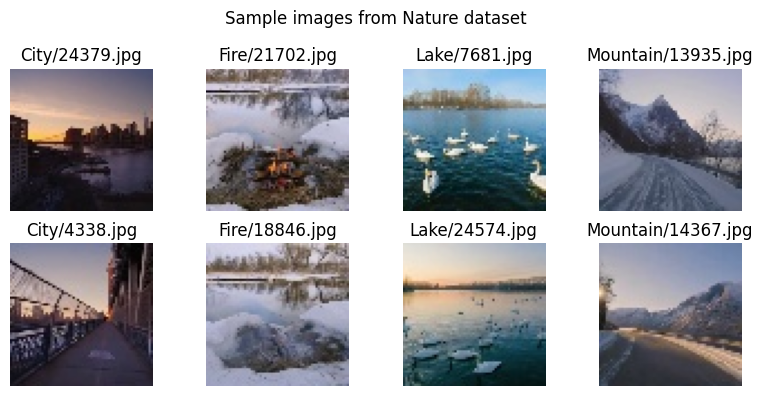

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))

for i, dir in enumerate(directories):
    files = os.listdir(os.path.join(data_path, dir))
    random_files = random.sample(files, 2)
    for j in range(2):
        img = Image.open(os.path.join(data_path, dir, random_files[j]))
        axs[j, i].imshow(img)
        axs[j, i].axis('off')
        axs[j, i].set_title(f"{dir}/{random_files[j]}")

plt.suptitle('Sample images from Nature dataset')
plt.tight_layout()
plt.show()

## Number of images in classes

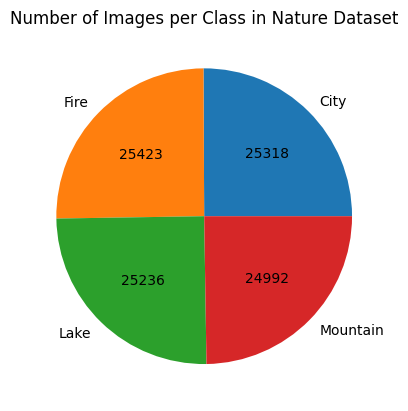

In [6]:
image_counts = [len([f for f in os.listdir(os.path.join(data_path, dir))]) for dir in directories]

plt.pie(image_counts, labels=directories, autopct=lambda p: '{:.0f}'.format(p * sum(image_counts) / 100))

plt.title('Number of Images per Class in Nature Dataset')

plt.show()

As can be seen in the plot above, the classes are balanced.

## Color distribution

Mountain: 100%|██████████| 24992/24992 [02:53<00:00, 144.23it/s]


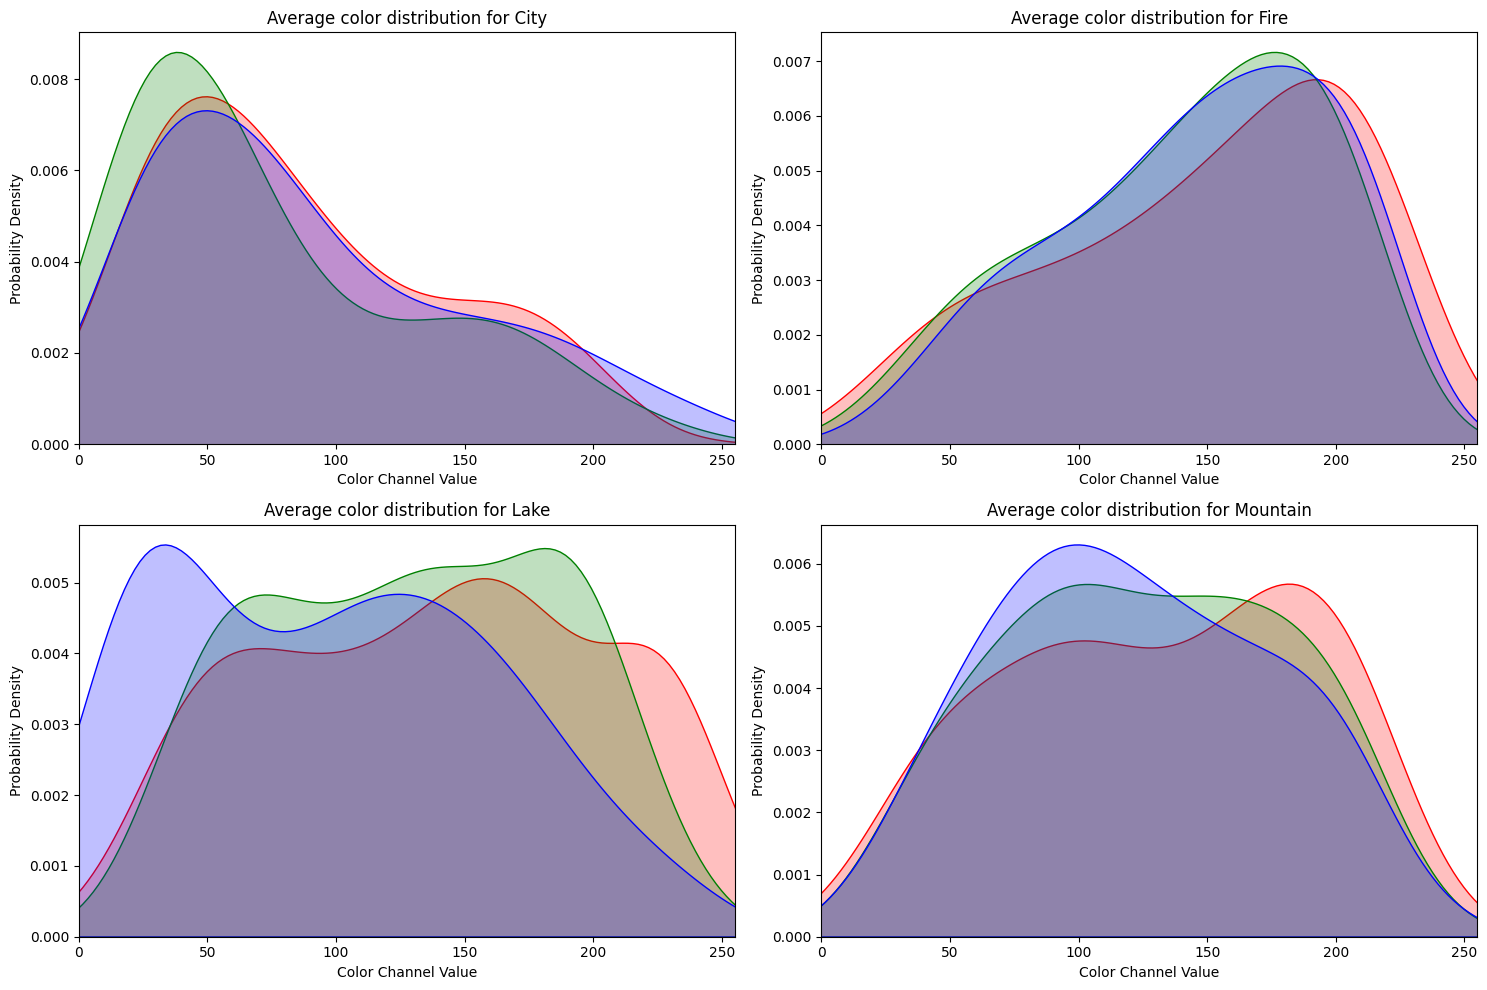

In [32]:
color = ('r', 'g', 'b')

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
dirs = iter(directories)

for i in range(2):
    for j in range(2):
        dir = next(dirs)
        avg_hist = {col: np.zeros((256,)) for col in color}
        files = os.listdir(os.path.join(data_path, dir))
        for file in tqdm(files, desc=dir):
            img = cv2.imread(os.path.join(data_path, dir, file))
            for k, col in enumerate(color):
                histr = cv2.calcHist([img],[k],None,[256],[0,256])
                avg_hist[col] += histr.ravel()
        for col in color:
            avg_hist[col] /= len(files)
            avg_hist[col] /= avg_hist[col].sum()
            sns.kdeplot(x=np.arange(256), weights=avg_hist[col], color=col, fill=True, ax=axs[i, j])
        axs[i, j].set_xlim([0, 255])
        axs[i, j].set_xlabel('Color Channel Value')
        axs[i, j].set_ylabel('Probability Density')
        axs[i, j].set_title(f'Average color distribution for {dir}')
plt.tight_layout()
plt.show()

## Brightness distribution of images

Mountain: 100%|██████████| 24992/24992 [03:01<00:00, 137.83it/s]


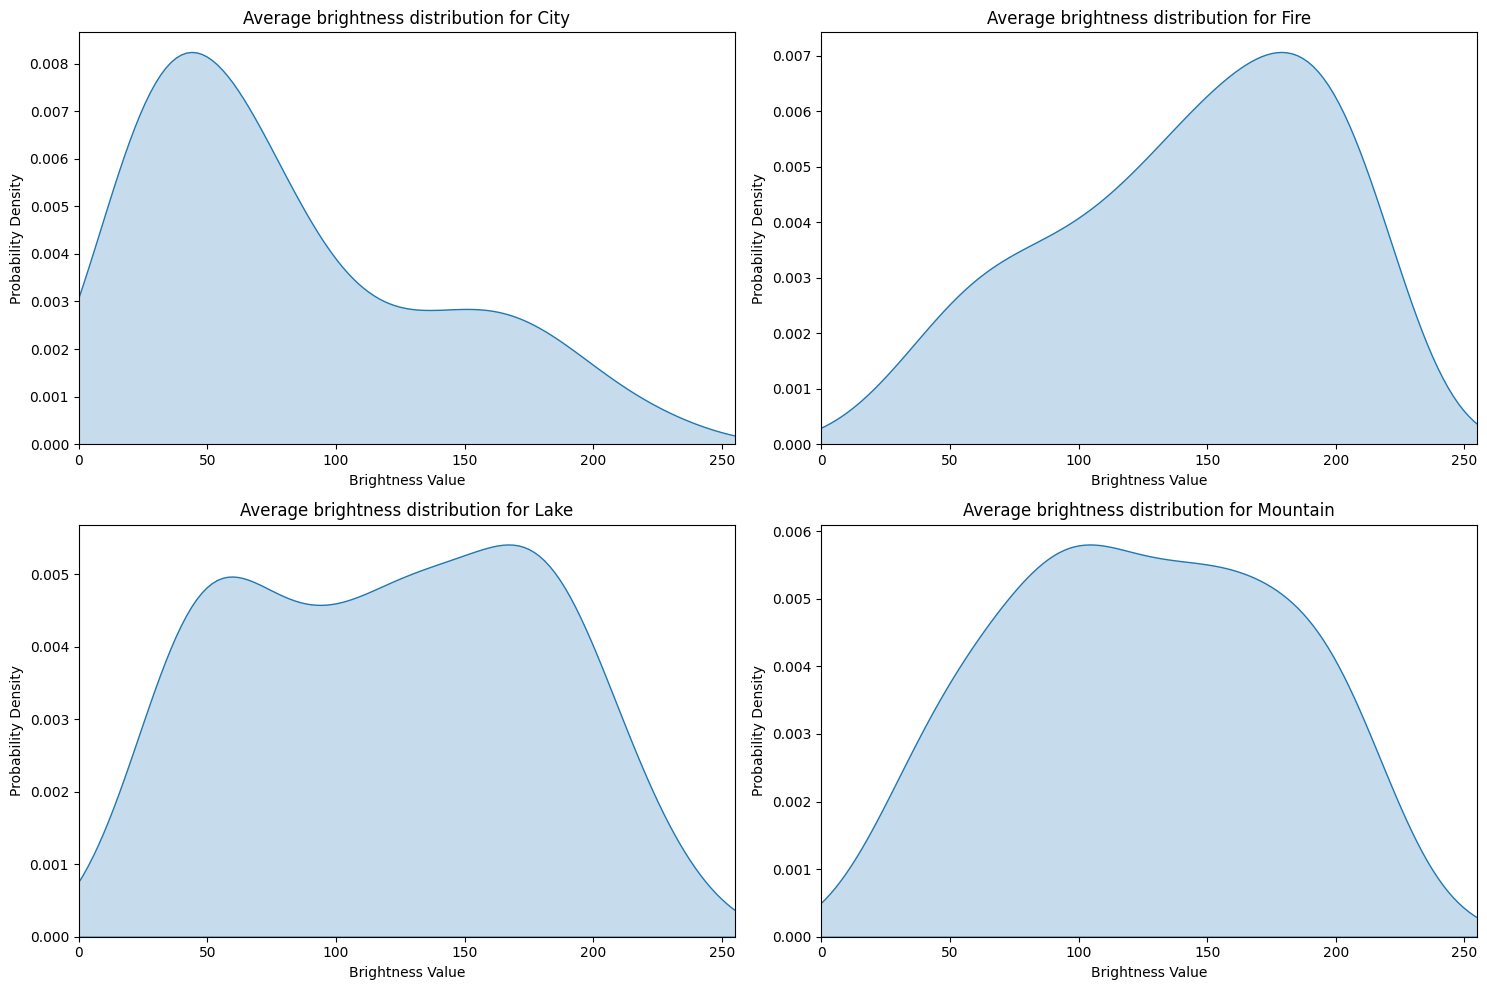

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
dirs = iter(directories)

for i in range(2):
    for j in range(2):
        dir = next(dirs)
        avg_hist = np.zeros((256,))
        files = os.listdir(os.path.join(data_path, dir))
        for file in tqdm(files, desc=dir):
            img = cv2.imread(os.path.join(data_path, dir, file))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            histr = cv2.calcHist([gray],[0],None,[256],[0,256])
            avg_hist += histr.ravel()
        avg_hist /= len(files)
        avg_hist /= avg_hist.sum()
        sns.kdeplot(x=np.arange(256), weights=avg_hist, fill=True, ax=axs[i, j])
        axs[i, j].set_xlim([0, 255])
        axs[i, j].set_xlabel('Brightness Value')
        axs[i, j].set_ylabel('Probability Density')
        axs[i, j].set_title(f'Average brightness distribution for {dir}')
plt.tight_layout()
plt.show()

## Image Embeddings

To help understand the structure and diversity of the dataset and ultimately guide the preprocessing steps and model design for the image inpainting task, an embedding analysis will be performed. The steps of the analysis will include:
- Using pre-trained models to extract high-dimensional feature vectors from the image dataset.
- Applying dimensionality reduction techniques such as PCA and t-SNE to encapsulate critical visual information.
- Enabling effective visualization and identification of underlying patterns and clusters within the data through these features.

### Embeddings calculation

In [3]:
# Load pre-trained model
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


def image_to_tensor(img_path):
    img = Image.open(img_path)
    img_t = preprocess(img)
    return img_t.unsqueeze(0)


def get_embedding(img_tensor):
    with torch.no_grad():
        emb = model(img_tensor)
    return emb.numpy().flatten()

In [4]:
embeddings_dict = {}

for dir_name in os.listdir(data_path):
    dir_path = os.path.join(data_path, dir_name)
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        embeddings = np.array([get_embedding(image_to_tensor(os.path.join(dir_path, file))) for file in files[:500]])
        embeddings_dict[dir_name] = embeddings

### PCA Analysis

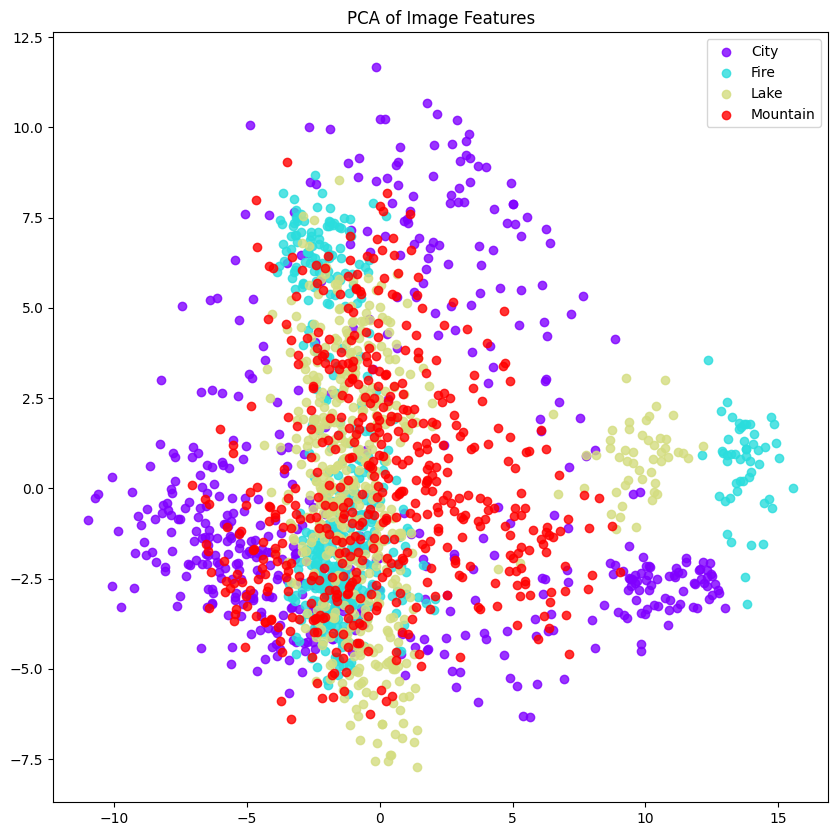

In [47]:
pca = PCA(n_components=50)

plt.figure(figsize=(10, 10))

colors = plt.cm.rainbow(np.linspace(0, 1, len(embeddings_dict)))

for (class_name, embeddings), color in zip(embeddings_dict.items(), colors):
    pca_result = pca.fit_transform(embeddings)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], color=color, alpha=0.8, label=class_name)

plt.title("PCA of Image Features")
plt.legend()
plt.show()

Based on the PCA plot provided:
- **Distinct Clusters:** distinct clusters for "Lake" and "Mountain" categories, which suggests that PCA also effectively separates these image features.
- **Overlapping** Some overlap exists between "City" and "Fire" categories, hinting at similar visual features or possible mislabeling in the data.
- **Fire Outliers:** The "Fire" category has outliers, which might be unusual images.

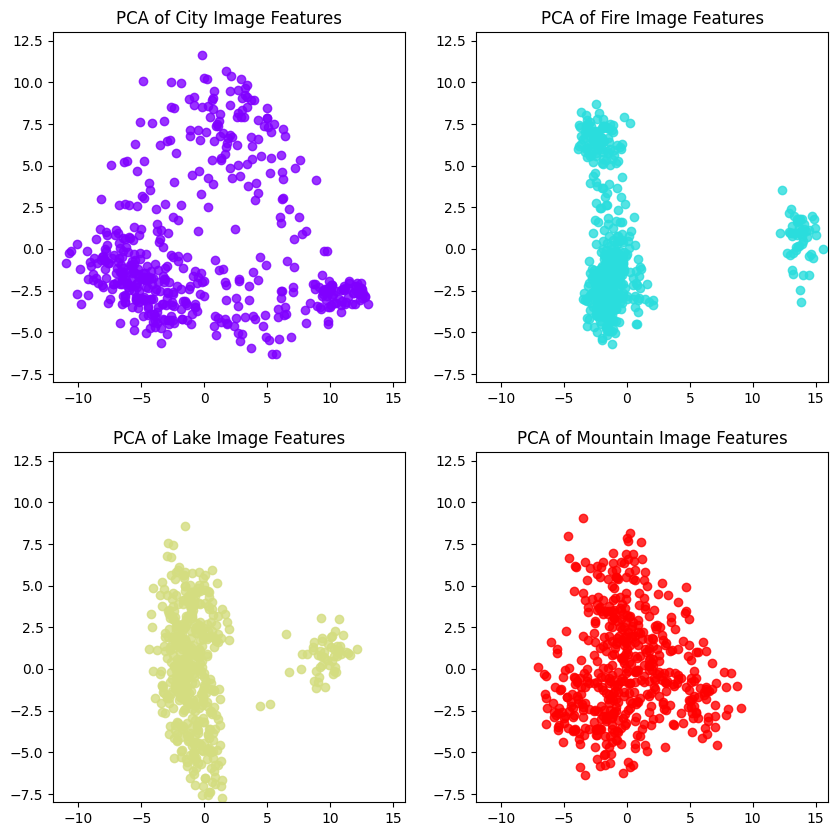

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax in axs.flat:
    ax.set(xlim=(-12, 16), ylim=(-8, 13))

class_to_ax = {
    'City': axs[0, 0],
    'Fire': axs[0, 1],
    'Lake': axs[1, 0],
    'Mountain': axs[1, 1],
}

colors = plt.cm.rainbow(np.linspace(0, 1, len(embeddings_dict)))

for (class_name, embeddings), color in zip(embeddings_dict.items(), colors):
    pca_result = pca.fit_transform(embeddings)
    ax = class_to_ax[class_name]
    ax.scatter(pca_result[:, 0], pca_result[:, 1], color=color, alpha=0.8)
    ax.set_title(f"PCA of {class_name} Image Features")

plt.show()

### TSNE Analysis

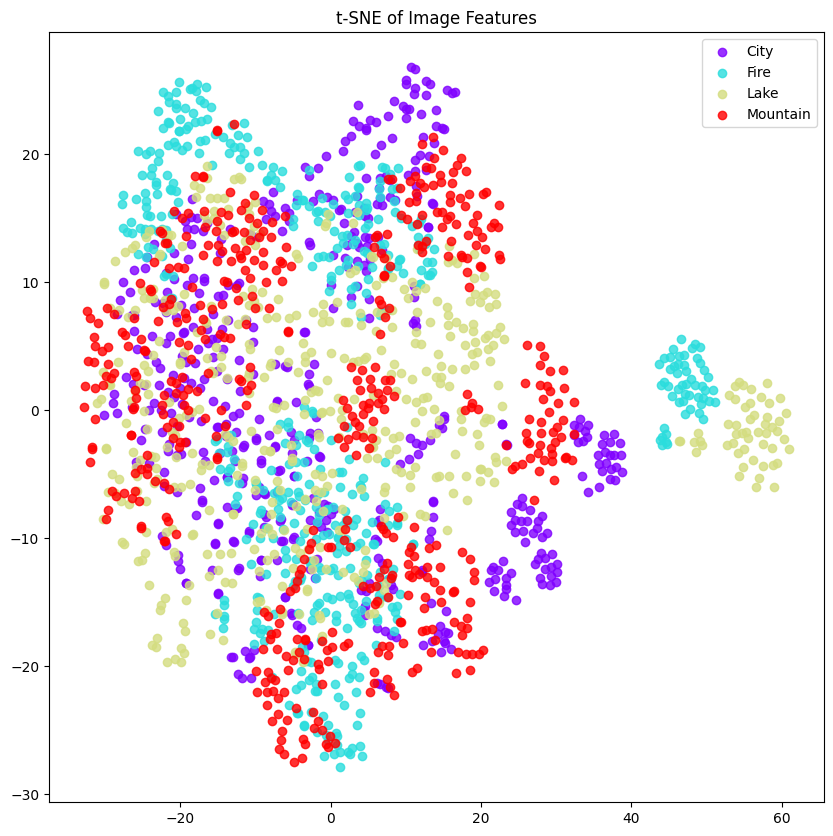

In [51]:
tsne = TSNE(n_components=2)

plt.figure(figsize=(10, 10))

colors = plt.cm.rainbow(np.linspace(0, 1, len(embeddings_dict)))

for (class_name, embeddings), color in zip(embeddings_dict.items(), colors):
    tsne_result = tsne.fit_transform(embeddings)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], color=color, alpha=0.8, label=class_name)

plt.title("t-SNE of Image Features")
plt.legend()
plt.show()

Based on the t-SNE plot of image embeddings:
- **Clear Separation:** "Lake" and "Mountain" images cluster distinctly, showing the embeddings successfully capture their unique visual properties.
- **Overlapping:** Some overlap exists between "City" and "Fire" categories, hinting at similar visual features or possible mislabeling in the data.
- **Fire Outliers:** The "Fire" category has outliers, which might be unusual images
- **Category Variation:** The spread of points differs across categories, reflecting the varying levels of diversity within each image type.

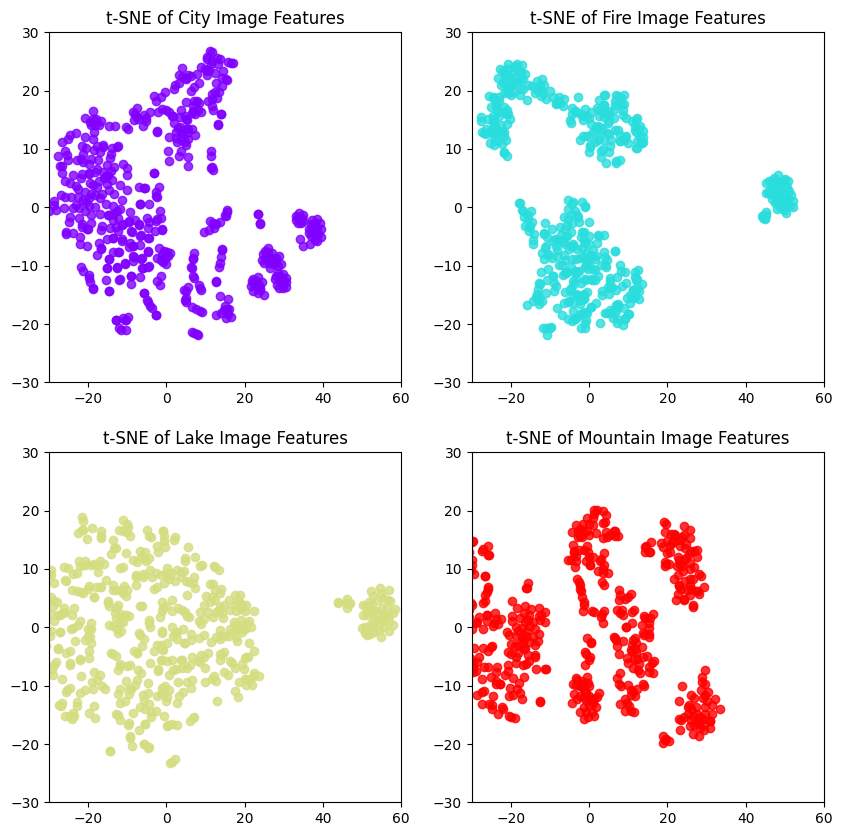

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Ensure same axes range for all subplots
for ax in axs.flat:
    ax.set(xlim=(-30, 60), ylim=(-30, 30))

# Map class names to subplot axes
class_to_ax = {
    'City': axs[0, 0],
    'Fire': axs[0, 1],
    'Lake': axs[1, 0],
    'Mountain': axs[1, 1],
}

colors = plt.cm.rainbow(np.linspace(0, 1, len(embeddings_dict)))

tsne = TSNE(n_components=2)

for (class_name, embeddings), color in zip(embeddings_dict.items(), colors):
    tsne_result = tsne.fit_transform(embeddings)
    ax = class_to_ax[class_name]
    ax.scatter(tsne_result[:, 0], tsne_result[:, 1], color=color, alpha=0.8)
    ax.set_title(f"t-SNE of {class_name} Image Features")

plt.show()

### Image Correlation Analysis

In [9]:
correlation = {}

for class_name, embeddings in embeddings_dict.items():
    embeddings_df = pd.DataFrame(embeddings)
    correlation_matrix = embeddings_df.corr()

    # Get the indices of the upper triangle of the correlation matrix, excluding the diagonal
    upper_tri_indices = np.triu_indices(correlation_matrix.shape[0], k=1)

    # Calculate the mean, max, min, and std using only the upper triangle values
    mean_cor = correlation_matrix.values[upper_tri_indices].mean()
    max_cor = correlation_matrix.values[upper_tri_indices].max()
    min_cor = correlation_matrix.values[upper_tri_indices].min()
    std_cor = correlation_matrix.values[upper_tri_indices].std()

    # Calculate the percentage of highly positive and negative correlations
    total_correlations = len(upper_tri_indices[0])
    high_pos_cor = (correlation_matrix.values[upper_tri_indices] > 0.75).sum()
    high_neg_cor = (correlation_matrix.values[upper_tri_indices] < -0.75).sum()
    high_pos_cor_percent = (high_pos_cor / total_correlations) * 100
    high_neg_cor_percent = (high_neg_cor / total_correlations) * 100

    correlation[class_name] = {
        'Mean Correlation': mean_cor,
        'Max Correlation': max_cor,
        'Min Correlation': min_cor,
        'Std Deviation': std_cor,
        'Highly Positive Correlations': high_pos_cor_percent,
        'Highly Negative Correlations': high_neg_cor_percent,
    }

display(pd.DataFrame(correlation).T)

,Mean Correlation,Max Correlation,Min Correlation,Std Deviation,Highly Positive Correlations,Highly Negative Correlations
City,0.035340,0.841251,-0.693326,0.192562,0.010702,0.000000
Fire,0.011917,0.925900,-0.861226,0.279317,0.245383,0.041279
Lake,0.030966,0.780223,-0.729818,0.190046,0.001529,0.000000
Mountain,0.027057,0.686925,-0.549062,0.138047,0.000000,0.000000


The entire dataset tends not to be correlated, which is positive information in the context of further work with it.

As can be seen, the largest number of highly positively and highly negatively correlated images are in the fire class, which makes sense because this is a film in which the camera stands still.
